In [1]:
import os
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import pmdarima as pm
from pmdarima import pipeline, arima, model_selection
from sklearn.metrics import mean_squared_error
import pandas as pd
import pickle
from tqdm import tqdm

Provided Code to Load Data

In [2]:
# Load the data
price_path = os.path.join(os.getcwd(),'elspotprices_19to21.csv')
df_prices = pd.read_csv(price_path)
df_prices['HourUTC'] = pd.to_datetime(df_prices["HourUTC"])
# Remove timezone information
df_prices["HourUTC"] = df_prices["HourUTC"].dt.tz_localize(None)
# Sort values
df_prices = df_prices.sort_values('HourUTC')
df_prices = df_prices.reset_index(drop=True)
# Load the data
Exog_path = os.path.join(os.getcwd(),'production_19to21.csv')
df_exog = pd.read_csv(Exog_path)
df_exog['HourUTC'] = pd.to_datetime(df_exog["HourUTC"])
# Sort values
df_exog = df_exog.sort_values('HourUTC')
df_exog = df_exog.reset_index(drop=True)

### Changing Dataset
Remove HourDK, SpotPriceEUR, and choose DK1 as the region of interest

In [3]:
df_prices = df_prices.loc[df_prices["PriceArea"] == 'DK1']
df_prices = df_prices.drop(columns=['HourDK','SpotPriceEUR'])
df_prices = df_prices.reset_index(drop=True)

df_exog = df_exog.loc[df_exog["PriceArea"] == 'DK1']
df_exog = df_exog.drop(columns=['HourDK'])
df_exog = df_exog.reset_index(drop=True)

Reduce df_prices & df_exog size to only have only data from the date specified onwards

In [4]:
start_train_date = '2021-08-30T23:00:00.000'

df_prices_start_date = np.min(df_prices.index[df_prices['HourUTC'] == start_train_date])
df_prices = df_prices[df_prices_start_date:]
df_prices = df_prices.reset_index(drop=True)

df_exog_start_date = np.min(df_exog.index[df_exog['HourUTC'] == start_train_date])
df_exog = df_exog[df_exog_start_date:]
df_exog = df_exog.reset_index(drop=True)

#### Training and Testing Datasets
Seperate test data and training data

In [5]:

#get index of the given end training set date
end_training_set_date = '2021-12-01T00:00:00.000'
set_train_size = np.max(df_prices.index[df_prices['HourUTC'] == end_training_set_date])

train, test = model_selection.train_test_split(df_prices, train_size=set_train_size)
X_train, X_test = model_selection.train_test_split(df_exog, train_size=set_train_size)

train = train["SpotPriceDKK"].values
test = test["SpotPriceDKK"].values
data = df_prices['SpotPriceDKK'].values

n_train = len(train)
n_test = len(test)
n_data = len(data)

## Task 1
Develop an ARIMA model to predict electricity prices. Your goal in all following tasks is to
achieve the best possible performance. In all sub-tasks, report the RMSE values you achieve
with your models. Pick a zone (DK1 or DK2) of your liking

### Task 1.1
Use NO exogenous variables in your model and make hour-ahead and day-ahead prediction
for your testing dataset. You can use a seasonal ARIMA or FourierFeaturizer and any data
transformation you want in your model, but no features from the production 19to21 dataset.
Establish a suitable persistence forecast, and report the RMSE values in all 4 cases (your model
and persistence, and for both hour-ahead and day-ahead). Briefly discuss your results and the
difference between the two forecasting cases.

## Hour Models

Persistence Model

In [ ]:
time_length = 1

Persistence_hour = []

time_estimate_frames = int(len(test)/time_length)

for i in range(time_estimate_frames):

    spliced_estiamte_frame = data[len(train)+i*time_length-time_length:len(train)+(i+1)*time_length-time_length]
    Persistence_hour.extend(spliced_estiamte_frame)

RMSE_P_H = mean_squared_error(Persistence_hour, test)

ARIMA Model

In [ ]:
time_length = 1

ARIMA_Forecast_H = []

time_estimate_frames = int(len(test)/time_length)

#m is set to 24 due to the seasonal affect of the 24 hour energy cycle
ARIMA = pm.auto_arima(train, trace = True, seasonal=True, iter = 100)

for i in tqdm(range(time_estimate_frames)):
    time_step_forcast = ARIMA.predict(n_periods = time_length)

    ARIMA_Forecast_H.extend(time_step_forcast)

    ARIMA.update(test[i])

RMSE_A_H = mean_squared_error(ARIMA_Forecast_H, test)

Save model and forcasted values to a pickel so I dont have to run it again.

In [ ]:
filename = "arima_hour_seasonal"
model_dic = {'model': ARIMA, 'forcasted_values': ARIMA_Forecast_H}

with open(str(filename)+'.pkl','wb') as f:
    pickle.dump(model_dic,f)

Alternate Fourier Hour

In [ ]:
time_length = 1
time_estimate_frames = int(len(test)/time_length)

pipe = pipeline.Pipeline([
    ("fourier", pm.preprocessing.FourierFeaturizer(m=24*7, k = 24)),
    ("arima", arima.AutoARIMA(stepwise=False, trace=1, error_action="ignore",
                              seasonal=False, maxiter=100,
                              suppress_warnings=True))])

pipe.fit(train)

rolling_forecast = []

for i in tqdm(range(time_estimate_frames)):

    forecast= pipe.predict(n_periods=time_length)
    
    pipe.update(test[i*time_length:(i+1)*time_length])
    
    # Append the forecast to the rolling forecast list
    rolling_forecast.extend(forecast)

RMSE_F_H = mean_squared_error(rolling_forecast, test)

In [ ]:
filename = "fourier_hour_m168_k24_"
model_dic = {'model': pipe, 'forcasted_values': rolling_forecast}

with open(str(filename)+'.pkl','wb') as f:
    pickle.dump(model_dic,f)

## Day Models

Persistence Model

In [ ]:
persistence_time_length = 24

Persistence_day = []

time_estimate_frames = int(len(test)/persistence_time_length)

for i in range(time_estimate_frames):

    spliced_estiamte_frame = data[len(train)+i*persistence_time_length-persistence_time_length:len(train)+(i+1)
    *persistence_time_length-persistence_time_length]
    
    Persistence_day.extend(spliced_estiamte_frame)

RMSE_P_D = mean_squared_error(Persistence_day, test)

ARIMA Model

In [ ]:
time_length = 24

ARIMA_Forecast_D = []

time_estimate_frames = int(len(test)/time_length)

#m is set to 24* due to the seasonal affect of the 24*7 hour energy cycle
ARIMA = pm.auto_arima(train, trace = True, seasonal=True, iter = 100)

for i in tqdm(range(time_estimate_frames)):
    
    time_step_forcast = ARIMA.predict(n_periods = time_length)

    ARIMA_Forecast_D.extend(time_step_forcast)

    ARIMA.update(test[i*time_length:(i+1)*time_length])

RMSE_A_D = mean_squared_error(ARIMA_Forecast_D, test)

In [ ]:
filename = "arima_day_seasonal"
model_dic = {'model': ARIMA, 'forcasted_values': ARIMA_Forecast_D}

with open(str(filename)+'.pkl','wb') as f:
    pickle.dump(model_dic,f)

Alternate Fourier Model

In [ ]:
time_length = 24
time_estimate_frames = int(len(test)/time_length)

pipe = pipeline.Pipeline([
    ("fourier", pm.preprocessing.FourierFeaturizer(m=24*7, k = 24)),
    ("arima", arima.AutoARIMA(stepwise=False, trace=1, error_action="ignore",
                              seasonal=False, maxiter=100,
                              suppress_warnings=True))])

pipe.fit(train)

rolling_forecast = []

for i in tqdm(range(time_estimate_frames)):

    forecast= pipe.predict(n_periods=time_length)
    
    pipe.update(test[i*time_length:(i+1)*time_length])
    
    # Append the forecast to the rolling forecast list
    rolling_forecast.extend(forecast)

RMSE_F_D = mean_squared_error(rolling_forecast, test)

In [ ]:
filename = "fourier_day_m168_k24_"
model_dic = {'model': pipe, 'forcasted_values': rolling_forecast}

with open(str(filename)+'.pkl','wb') as f:
    pickle.dump(model_dic,f)

Report the RMSE values in all 4 cases (your model
and persistence, and for both hour-ahead and day-ahead). Briefly discuss your results and the
difference between the two forecasting cases.

In [ ]:
fourier_hour = 'fourier_hour_m168_k24_'
#fourier_hour_exog = 'fourier_hour_m168_k24_exog_ExchangeSE_MWh_ OffshoreWindGe100MW_MWh_PowerToHeatMWh'
fourier_day = 'fourier_day_m168_k24_'
#fourier_day_exog = 'fourier_day_m168_k24_exog_ExchangeSE_MWh_OffshoreWindGe100MW_MWh_PowerToHeatMWhtest'

model_list = ['fourier_hour_m168_k24_','fourier_day_m168_k24_']

RMSE_list = {}

for model in model_list:
    with open(model + '.pkl', 'rb') as f:
        model_dict = pickle.load(f)

    model_info = model_dict['model']
    forcasted_values = model_dict['forcasted_values']

    RMSE_list[model] = mean_squared_error(forcasted_values, test)

RMSE_list['Persistence_Day'] = mean_squared_error(Persistence_day,test)
RMSE_list['Persistence_Hour'] = mean_squared_error(Persistence_hour,test)

RMSE_list = np.transpose(np.array([list(RMSE_list.keys()),list(RMSE_list.values())]))

print(RMSE_list)


### Task 1.2
Add any exogenous variables you want (maximum 3) and repeat the process (choose/optimize your
model and evaluate it for the hour-ahead and the day-ahead prediction). What exogenous
variables helped you improve the prediction and how did you choose the specific ones? Compare
your results with those from task 1.1 and briefly discuss them.

In [ ]:
df_exog['SpotPriceDKK'] = df_prices['SpotPriceDKK']
correlate = df_exog.iloc[:,3:].corr()

X_train = X_train[["ExchangeSE_MWh", "OffshoreWindGe100MW_MWh","PowerToHeatMWh"]].values
X_test = X_test[["ExchangeSE_MWh", "OffshoreWindGe100MW_MWh","PowerToHeatMWh"]].values

n_X_train = len(X_train)
n_X_test = len(X_test)

X_train_ar = np.column_stack([np.arange(1,n_X_train+1),X_train])

In [ ]:
fig, ax = plt.subplots()

#removing columns
df_exog = df_exog.drop("HourDK", axis=1)


# plot each column of the DataFrame as a line
df_exog.plot(ax=ax)

# set the x and y axis labels
ax.set_xlabel('Index')
ax.set_ylabel('Value')

# set the title of the plot
ax.set_title('Line Plot of DataFrame')

# show the plot
plt.show()

In [ ]:
#df_exog = df_exog.drop('PriceArea', axis = 1)
record = {}
for column in df_exog:
    current = np.correlate(df_exog[column], df_prices['SpotPriceDKK'])
    record[column] = [current]

record = np.transpose(np.array([list(record.keys()),list(record.values())]))

Hour Ahead Prediction

In [ ]:
time_length = 1

time_estimate_frames = int(len(test)/time_length)

pipe = pipeline.Pipeline([
    ("fourier", pm.preprocessing.FourierFeaturizer(m=24*7, k = 24)),
    ("arima", arima.AutoARIMA(stepwise=False, trace=1, error_action="ignore",
                              seasonal=False, maxiter=100,
                              suppress_warnings=True))])

pipe.fit(train, X = X_train_ar)

rolling_forecast = []

for i in tqdm(range(time_estimate_frames)):

    X_f = np.column_stack([np.arange(1, time_length+1), X_test[i*time_length:(i+1)*time_length]])

    forecast = pipe.predict(n_periods=time_length, X=X_f)
    
    pipe.update(test[i*time_length:(i+1)*time_length], X = X_f)
    
    # Append the forecast to the rolling forecast list
    rolling_forecast.extend(forecast)

#Do I need this line? Not sure
rolling_forecast = [0 if x < 0 else x for x in rolling_forecast]

RMSE_F_H = mean_squared_error(rolling_forecast, test)

In [ ]:
filename = "fourier_hour_m168_k24_exog_ExchangeSE_MWh_ OffshoreWindGe100MW_MWh_PowerToHeatMWh"
model_dic = {'model': pipe, 'forcasted_values': rolling_forecast}

with open(str(filename)+'.pkl','wb') as f:
    pickle.dump(model_dic,f)

Day Ahead Prediction

In [ ]:
time_length = 24

time_estimate_frames = int(len(test)/time_length)

pipe = pipeline.Pipeline([
    ("fourier", pm.preprocessing.FourierFeaturizer(m=24*7, k = 24)),
    ("arima", arima.AutoARIMA(stepwise=False, trace=1, error_action="ignore",
                              seasonal=False, maxiter=100,
                              suppress_warnings=True))])

pipe.fit(train, X = X_train_ar)

rolling_forecast = []

for i in tqdm(range(time_estimate_frames)):

    X_f = np.column_stack([np.arange(1, time_length+1), X_test[i*time_length:(i+1)*time_length]])

    forecast= pipe.predict(n_periods=time_length, X=X_f)
    
    pipe.update(test[i*time_length:(i+1)*time_length], X=X_f)
    
    # Append the forecast to the rolling forecast list
    rolling_forecast.extend(forecast)

rolling_forecast = [0 if x < 0 else x for x in rolling_forecast]

RMSE_F_D = mean_squared_error(rolling_forecast, test)

In [ ]:
filename = "fourier_day_m168_k24_exog_ExchangeSE_MWh_OffshoreWindGe100MW_MWh_PowerToHeatMWh"
model_dic = {'model': pipe, 'forcasted_values': rolling_forecast}

with open(str(filename)+'test.pkl','wb') as f:
    pickle.dump(model_dic,f)

In [ ]:
fourier_hour = 'fourier_hour_m168_k24_'
fourier_hour_exog = 'fourier_hour_m168_k24_exog_ExchangeSE_MWh_ OffshoreWindGe100MW_MWh_PowerToHeatMWh'
fourier_day = 'fourier_day_m168_k24_'
fourier_day_exog = 'fourier_day_m168_k24_exog_ExchangeSE_MWh_OffshoreWindGe100MW_MWh_PowerToHeatMWhtest'

day_model_list = ['fourier_day_m168_k24_','fourier_day_m168_k24_exog_ExchangeSE_MWh_OffshoreWindGe100MW_MWh_PowerToHeatMWhtest']

hour_model_list = ['fourier_hour_m168_k24_','fourier_hour_m168_k24_exog_ExchangeSE_MWh_ OffshoreWindGe100MW_MWh_PowerToHeatMWh']

RMSE_list = []

for model in day_model_list:
    with open(model + '.pkl', 'rb') as f:
        model_dict = pickle.load(f)

    model_info = model_dict['model']
    forcasted_values = model_dict['forcasted_values']

    RMSE_list.append(["Day", model, mean_squared_error(forcasted_values, test)])

RMSE_list.append(["Day", 'Persistence_Day',mean_squared_error(Persistence_day,test)])

for model in hour_model_list:
    with open(model + '.pkl', 'rb') as f:
        model_dict = pickle.load(f)

    model_info = model_dict['model']
    forcasted_values = model_dict['forcasted_values']

    RMSE_list.append(["Hour", model, mean_squared_error(forcasted_values, test)])

RMSE_list.append(["Hour", 'Persistence_Hour', mean_squared_error(Persistence_hour,test)])

print(RMSE_list)


# Task 2
Develop a temporal Convolutional Neural Network (tCNN) to predict the electricity prices.
Your goal in all following tasks is to achieve an as good performance as possible.

In [26]:
import torch
from torch import nn, optim
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

Create a new dataframe for all network data and specifiy the features (exog variables & time) and target (SpotPrice)

In [40]:
#remove duplicate label
#df_exog = df_exog.drop(["HourUTC"], axis=1)

df_network = pd.concat([df_prices, df_exog], axis = 1)
df_network['Hour'] = df_network['HourUTC'].dt.hour

features = ["ExchangeSE_MWh","OffshoreWindGe100MW_MWh","PowerToHeatMWh",'Hour']
targets = ["SpotPriceDKK"]

Split into testing and training data

In [41]:
train_data, test_data = model_selection.train_test_split(df_network, train_size=set_train_size)

train_features = train_data[features]
test_features = test_data[features]

train_labels = train_data[targets] 
test_labels = test_data[targets]

Normalise the numerical inputs before applying them to the neural network
model

In [43]:
    
def normalize_df(df):
    df.set_index("Hour", inplace=True)

    normalize = df.columns[df.columns != "Hour"]

    scaler = StandardScaler()

    df[normalize] = scaler.fit_transform(df[normalize])

    df.reset_index(inplace=True)

normalize_df(train_features)
normalize_df(test_features)


C:\Users\birdl\AppData\Local\Temp\ipykernel_28252\1785373184.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[normalize] = scaler.fit_transform(df[normalize])
C:\Users\birdl\AppData\Local\Temp\ipykernel_28252\1785373184.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[normalize] = scaler.fit_transform(df[normalize])


In [44]:
from sklearn.model_selection import train_test_split
train_features , val_features , train_labels , val_labels  = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)

Use inbuilt 'Dataset' class to prepare the data
The dataset class is a Pytorch class that characterizes the key features of the dataset you want to generate

In [45]:
class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, features, labels):
            'Initialization'
            self.labels = torch.tensor(labels.values) # Target variable
            self.features = torch.tensor(features.values, dtype=torch.float) #Input features

    def __len__(self):
            'Denotes the total number of samples in the dataset'
            return len(self.features)

    def __getitem__(self, index):
            'Generates one sample of data'
            # Load data and get label
            X = self.features[index]
            y = self.labels[index]

            return X, y

Build a neural network with pytorch

In [46]:
class NNModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_class):
        '''
        input_size: specifies the number of features
        hidden_size: specifies the number of neurons in the hidden layer
        num_class: number of classes for classification
        '''
        super().__init__()  #initializes the torch.nn.Module
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.out_layer = nn.Linear(hidden_size, num_class)
        self.relu = nn.ReLU() # Activation function
        # For more information:https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.out_layer(x)
        return x

Define network hyperparameters

In [47]:
# Training configurations
num_epochs = 100 #Number of epochs

# Architecture
input_size = len(features)
hidden_size = 20
num_class = 2

lr = 0.01 # Learning rate

# Parameters for the data loader
params = {'batch_size': 100, # Varry the batch size to find out it's influence accuracy and the rate of convergence
          'shuffle': True}

Instantiate Model

In [48]:
model = NNModel(input_size, hidden_size, num_class)

Generate Our Dataset

In [49]:
# Dataset Generators
training_set = Dataset(train_features, train_labels)
training_generator = torch.utils.data.DataLoader(training_set, **params)

val_set = Dataset(val_features, test_labels)
val_generator = torch.utils.data.DataLoader(val_set, **params)

test_set = Dataset(test_features, test_labels)
test_generator = torch.utils.data.DataLoader(test_set, **params)

Define Loss Function

In [50]:
loss_function = nn.L1Loss()

#### Optimizer
The optimizer modifies the weights and biases such that the loss is as small as possible

In [51]:
optimizer = optim.Adam(model.parameters(), # the model parameters being optimized
                      lr=lr  # learning rate
                     )

#### Function to calculate the accuracy

In [52]:
def binary_accuracy(y_pred, y_true):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = ((correct/2) / len(y_pred)) * 100 
    return acc

Train Model on Training Data

In [53]:
def train_model(model, training_generator, optimizer, loss_function):
    
    epoch_loss = 0
    epoch_acc = 0
  
    # set model to train mode
    model.train()
    
    for local_batch, local_labels in (training_generator):
        
        # resets gradient
        optimizer.zero_grad()
        
        # forward pass to compute predictions
        y_logits = model(local_batch)
        #compute the loss
        loss = loss_function(y_logits, local_labels.float())
        #compute the accuracy
        acc = binary_accuracy(y_logits, local_labels)        
        
        # backpropagation to compute updates model parameters based on loss
        loss.backward()
        
        # update the parameters
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc
  
    return epoch_loss/len(training_generator), epoch_acc /len(training_generator)

#### Evaluate model on test/validation data

In [54]:
def evaluate_model(model, test_generator, loss_function):
    epoch_loss = 0
    epoch_acc = 0
  
    # set evaluation mode
    model.eval()
  
    with torch.no_grad():
        for local_batch, local_labels in (test_generator):
            # compute predictions
            y_logits = model(local_batch)
            #compute the loss
            loss = loss_function(y_logits, local_labels.float())
            #compute the accuracy
            acc = binary_accuracy(y_logits, local_labels)        

            epoch_loss += loss.item()
            epoch_acc += acc

        return epoch_loss/len(test_generator), epoch_acc /len(test_generator)

c:\Users\birdl\anaconda3\envs\course02502\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([100, 1])) that is different to the input size (torch.Size([100, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
c:\Users\birdl\anaconda3\envs\course02502\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([67, 1])) that is different to the input size (torch.Size([67, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
c:\Users\birdl\anaconda3\envs\course02502\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([44, 1])) that is different to the input size (torch.Size([44, 2])). This will likely lead to incorrect results due to broadcasti

epoch: 11, train loss: 312.0202, train accuracy: 0.00%
epoch: 11, validation loss: 638.7987, validation accuracy: 0.00%
epoch: 21, train loss: 277.7044, train accuracy: 0.00%
epoch: 21, validation loss: 575.5252, validation accuracy: 0.00%
epoch: 31, train loss: 274.4981, train accuracy: 0.00%
epoch: 31, validation loss: 586.4621, validation accuracy: 0.00%
epoch: 41, train loss: 272.1250, train accuracy: 0.00%
epoch: 41, validation loss: 584.6393, validation accuracy: 0.00%
epoch: 51, train loss: 273.1511, train accuracy: 0.00%
epoch: 51, validation loss: 595.0097, validation accuracy: 0.00%
epoch: 61, train loss: 269.2196, train accuracy: 0.00%
epoch: 61, validation loss: 585.8925, validation accuracy: 0.00%
epoch: 71, train loss: 270.0388, train accuracy: 0.00%
epoch: 71, validation loss: 593.8732, validation accuracy: 0.00%
epoch: 81, train loss: 268.8330, train accuracy: 0.00%
epoch: 81, validation loss: 579.6116, validation accuracy: 0.00%
epoch: 91, train loss: 268.9470, train a

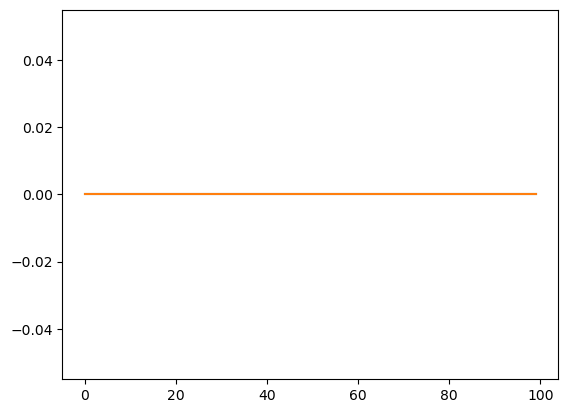

In [55]:
def predict_consumption(model):
    
    train_acc = []
    test_acc = []
    val_acc = []
    
    best_val_loss = float('inf')
    
    for epoch in range(1, 1 + num_epochs):

        train_loss, train_accuracy = train_model(model, training_generator, optimizer, loss_function)
        
        #Add code to evaluate your model on the test database
        epoch_loss, epoch_acc = evaluate_model(model, test_generator, loss_function)

        validation_loss, validation_accuracy = evaluate_model(model, val_generator, loss_function)
                
        # Add code to save the acccuracy at each epoch
        train_acc.append(train_accuracy)
        test_acc.append(epoch_acc)
        val_acc.append(validation_accuracy)
        
        #Save model with the best validation loss
        if validation_loss < best_val_loss:
            best_val_loss = validation_loss
            torch.save(model, 'model.pth')

        if epoch % 10 == 0:
            print(f'epoch: {epoch+1}, train loss: {train_loss:.4f}, train accuracy: {train_accuracy:.2f}%')
            print(f'epoch: {epoch+1}, validation loss: {validation_loss:.4f}, validation accuracy: {validation_accuracy:.2f}%')
        
    #Add code to plot the train and test accuracy against the epochs
    
    plt.plot(test_acc)
    plt.plot(train_acc)
predict_consumption(model)
               

### Task 2.1

Pick a maximum of 3 exogenous variables and perform the hour-ahead prediction for the
training dataset. Report the RMSE value you achieve with your model and compare with the
persistence RMSE you established in Task 1.